In [23]:
#import relevant libraries
import numpy as np
import emcee
import pandas as pd
import matplotlib.pyplot as plt
import corner


In [24]:
#set iPTF16hvw redshit and B band max
z_16hvw = .03663

MJD_max_16hvw = 57714.40

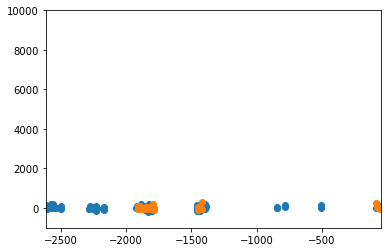

0     -2612.327475
1     -2609.477200
2     -2607.433945
3     -2607.427337
4     -2587.264279
5     -2587.189277
6     -2579.656319
7     -2579.552984
8     -2573.841264
9     -2573.749072
10    -2572.878973
12    -2569.945921
13    -2569.870880
14    -2568.864648
16    -2565.109142
17    -2565.029895
18    -2560.299721
19    -2560.215111
20    -2557.313892
21    -2556.566885
22    -2537.166221
23    -2537.123853
24    -2499.670326
25    -2499.627524
26    -2281.372428
27    -2280.405526
28    -2279.427067
29    -2278.473110
30    -2263.036927
31    -2254.352517
          ...     
106    -846.003830
107    -845.982665
108    -785.248536
109    -785.233458
110    -509.340324
111    -509.306773
112     -85.793600
113     -82.885842
114     -79.994598
115     -77.092309
116     -74.212844
117     -71.293509
118     -68.411622
119     -55.074848
120     -52.167996
121     -49.236526
122     -46.382374
124     -31.962378
125     -31.145375
126     -30.183132
127     -29.064546
128     -26.

In [49]:
#import the data
g = pd.read_csv('../Data/16hvw_photometry/16hvw_g_forced_flux.txt', sep=" " , header=None)
R = pd.read_csv('../Data/16hvw_photometry/16hvw_R_forced_flux.txt', sep=" " , header=None)

#convert to MJD
g[0] = g[0] - 2400000.5
R[0] = R[0] - 2400000.5

#convert times relative to SN max light in restframe
g[0] = (g[0] - MJD_max_16hvw) / (1 + z_16hvw)
R[0] = (R[0] - MJD_max_16hvw) / (1 +z_16hvw)

#Set column names 
g.columns = ['phase' , 'Flux' ,'Fluxerr']
R.columns =  ['phase' , 'Flux' ,'Fluxerr']


#get rid of bad data
R_bad_indices = np.where(np.logical_or(R['Fluxerr']< 0, R['Flux'] == 99999999.0))
g_bad_indices = np.where(np.logical_or(g['Fluxerr']< 0, g['Flux'] == 99999999.0))

R.drop(index=R_bad_indices[0], inplace=True)
g.drop(index=g_bad_indices[0], inplace=True)

#Get rid of post peak data
g = g[:-4]
R = R[:-4]

#plot data 
plt.errorbar(R['phase'],  R['Flux'], yerr=R['Fluxerr'], fmt='o' )
plt.errorbar(g['phase'] , g['Flux'], yerr=g['Fluxerr'], fmt ='o')
plt.xlim([np.min(R['phase']), -50])
plt.ylim([-1000,10000])
plt.show()
R['phase']

In [40]:
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles)
    
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

paramsNames=['a', 
           'b', 't_0', 'alpha', 'sig_0']

# likelihood function

# <center> $\prod_{i} \frac{1}{\sqrt{\pi ( \sigma_{i}^{2} + \sigma_{0}^{2}})} exp\bigg(\frac{-(y_{i} - (a + b(t-t_{0})^{\alpha}))}{\sigma_{i}^{2} + \sigma_{0}^{2}}\bigg) $
</centering>

# <center>$\prod_{i} \frac{1}{\sqrt{\pi ( \sigma_{i}^{2} + \sigma_{0}^{2} })} exp\bigg(\frac{-(y_{i} - a )}{\sigma_{i}^{2} + \sigma_{0}^{2}}\bigg)$
    
   

In [41]:
#Define the log likelihood
def lnlikelihood(theta, f, t, f_err):
    a, b, t_0, alpha, sig_0 = theta
    ln_l = 0
    for i in range(len(t)):
        if(t[i] < t_0):
            model = a
        elif(t[i] > t_0):
            model = a + (b*((t[i] - t_0)**alpha))
        ln_l += np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err[i]**2))) - ((f[i] - model)**2 / (2 * (sig_0**2 + f_err[i]**2)))
    return ln_l

#Define priors on parameters  
def lnprior(theta):
    a, b, t_0, alpha, sig_0 = theta
    if(-20 < t_0 < -10 and 0 < alpha < 5 and 0 < sig_0 < 100 and -100 < a < 100 and  0 < b < 100):
        return 0.0
    return -np.inf
   
def posterior(theta, f, t, f_err):
    prior = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(prior):
        return -np.inf
    return lnl + prior
    
   

In [42]:
#initial guess on parameters
guess_0 = [30 , 1 ,-16, 2, 100]



In [43]:
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(guess_0)
ncores=6
pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]
sampler_R = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(np.array(R['Flux']), np.array(R['phase']) , np.array(R['Fluxerr'])), threads = ncores)

nsamples = 6000
foo = sampler_R.run_mcmc(pos, nsamples)


In [45]:
# set a "burn-in" limit
nburn = 200
alpha_samples_R = np.array(sampler_R.chain[:,:nburn,3]).flatten()
t_0_samples_R = np.array(sampler_R.chain[:,:nburn,2]).flatten()

#print the results taking 1-sigma confidence intervals
samples_R = np.vstack([t_0_samples_R, alpha_samples_R]).T

t_0_mc_R, alpha_mc_R = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples_R, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_R[0], t_0_mc_R[1], t_0_mc_R[2], alpha_mc_R[0], alpha_mc_R[1], alpha_mc_R[2]))

emcee results with 1-sigma uncertainties
       t_0 = -18.8601 +2.8004 -0.7210
       alpha = 2.8487 +0.7414 -0.7879



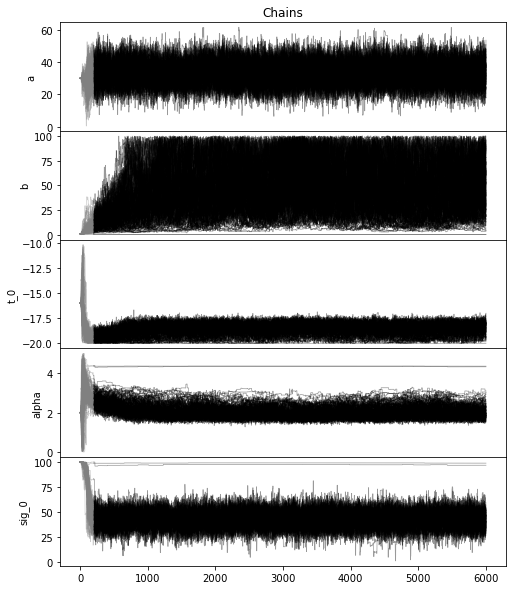

In [46]:
axR = plotChains(sampler_R, nburn, paramsNames)
plt.savefig('Chains')
plt.show()


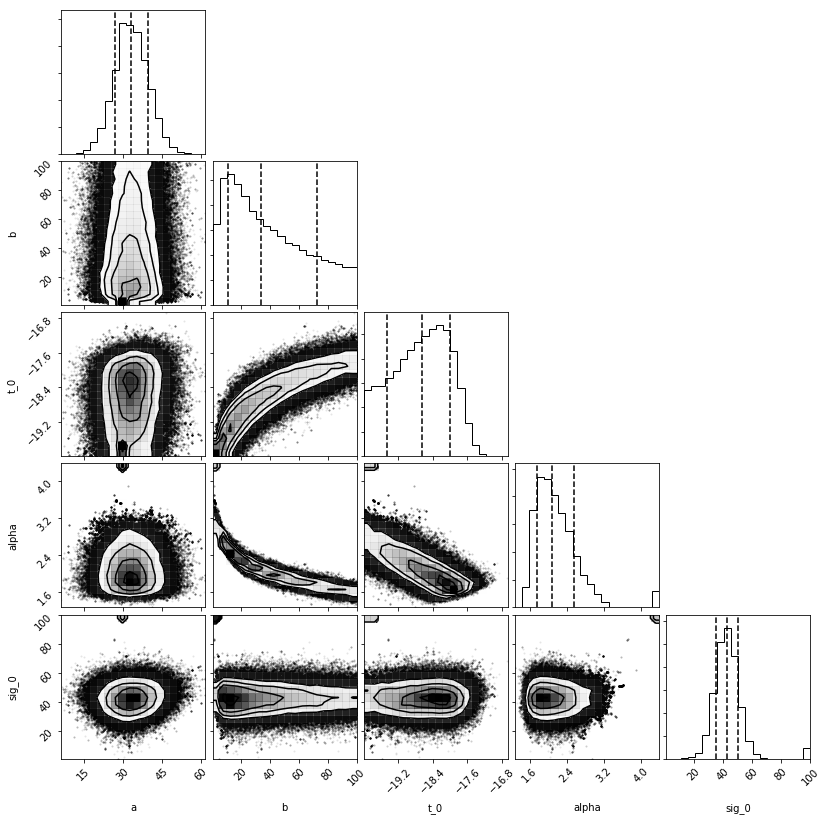

In [47]:
makeCorner(sampler_R, nburn, paramsNames)
plt.show()

In [53]:
sampler_g = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(np.array(g['Flux']), np.array(g['phase']) , np.array(g['Fluxerr'])), threads = ncores)
nsamples = 10000
foo = sampler_g.run_mcmc(pos, nsamples)


In [54]:
# set a "burn-in" limit
nburn = 200
alpha_samples_g = np.array(sampler_g.chain[:,:nburn,3]).flatten()
t_0_samples_g = np.array(sampler_g.chain[:,:nburn,2]).flatten()

#print the results taking 1-sigma confidence intervals
samples_g = np.vstack([t_0_samples_g, alpha_samples_g]).T

t_0_mc_g, alpha_mc_g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples_g, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_g[0], t_0_mc_g[1], t_0_mc_g[2], alpha_mc_g[0], alpha_mc_g[1], alpha_mc_g[2]))

emcee results with 1-sigma uncertainties
       t_0 = -18.5565 +2.5356 -0.8986
       alpha = 2.7507 +0.7625 -0.7265



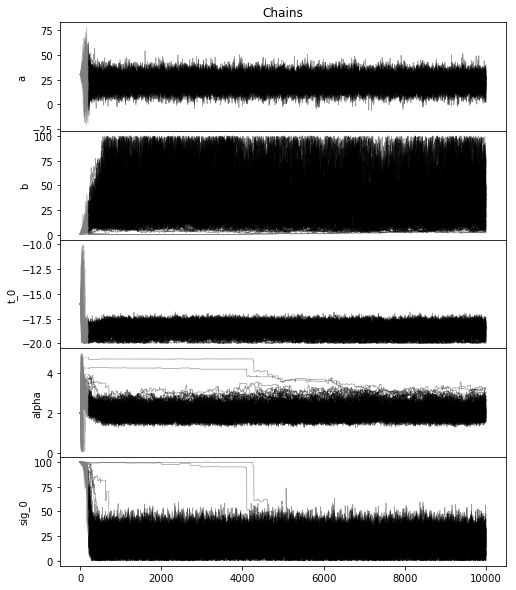

In [55]:
ax = plotChains(sampler_g, nburn, paramsNames)
plt.show()


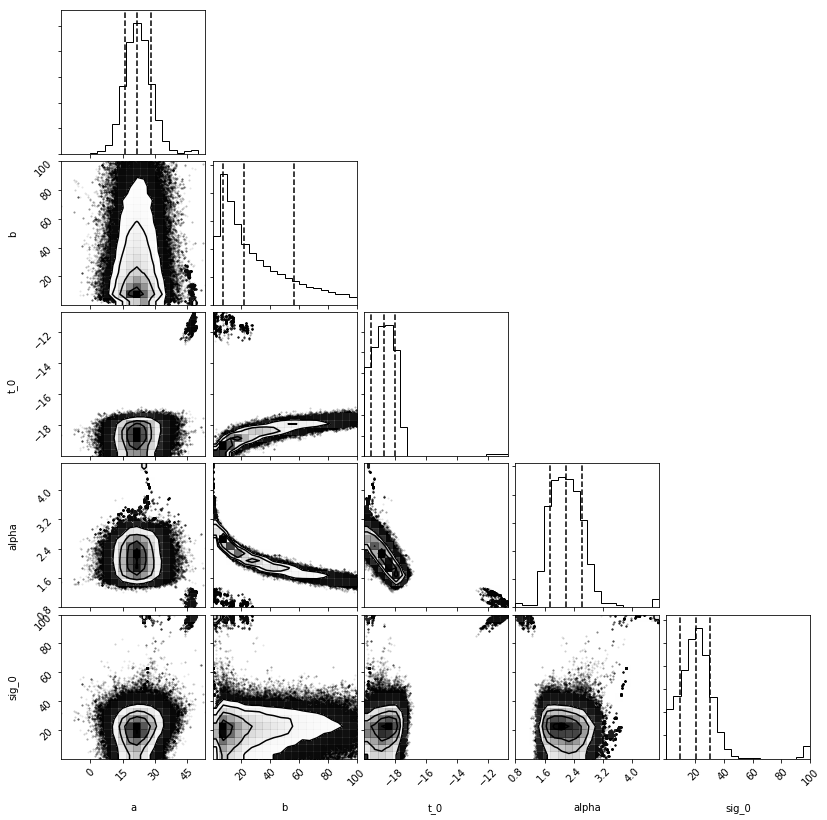

In [52]:
makeCorner(sampler_g, nburn, paramsNames)
plt.show()